In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import pandas as pd

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CustomDataset(Dataset):
    def __init__(self, file_path): 
        data = pd.read_csv(file_path)
        self.features = data.drop(columns=['objid', 'specobjid', 'class', 'run', 'rerun', 'camcol', 'field', 'ra', 'dec', 'redshift'], axis=1)
        print(len(self.features))
        print(self.features.shape[1])
        self.labels = data['class']

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features.iloc[index]
        label_str = self.labels.iloc[index]

        # Convert label string to integer
        if label_str == 'GALAXY':
            label = 0
        elif label_str == 'STAR':
            label = 1
        else:
            label = 2

        feature = torch.tensor(feature, dtype=torch.float32).to(device)  # Move feature tensor to GPU
        label = torch.tensor(label, dtype=torch.long).to(device)  # Move label tensor to GPU

        return feature, label

In [4]:
csv_file = 'photofeatures_exp3.csv'
dataset = CustomDataset(csv_file)
X = []
y = []

for i in range(len(dataset)):
    feature, label = dataset[i]
    X.append(feature)
    y.append(label)

X = torch.stack(X)
y = torch.stack(y)

28532
24


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, random_state=42)
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).long().to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).long().to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).long().to(device)

In [6]:
X_train = X_train.cpu()
y_train = y_train.cpu()
X_val = X_val.cpu()
y_val = y_val.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

In [11]:
model = svm.SVC()
model.fit(X_train,y_train)   

SVC()

In [12]:
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy for decision tree:", accuracy)

Validation Accuracy for decision tree: 0.704201680672269


In [13]:
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy for decision tree:", accuracy)

Test Accuracy for decision tree: 0.7003083823941688


In [14]:
precision = precision_score(y_test,y_test_pred,average='weighted',zero_division =0 )
recall = recall_score(y_test,y_test_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7517529000118003
Recall: 0.7003083823941688


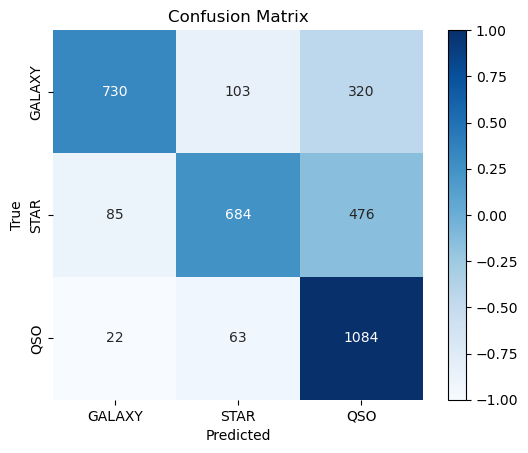

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
class_names = ['GALAXY', 'STAR', 'QSO']
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
dummy = plt.imshow([[-1, -1], [1, 1]], cmap='Blues')
plt.colorbar(dummy)
plt.show()